**Instituto Tecnológico de Costa Rica**

**Escuela de Ingeniería en Computación**

**Maestría Académica en Ciencias de la Computación**

**Curso:** Electiva Aprendizaje Automático

**Segundo Semestre 2025**

**Profesor:** Dr. Luis-Alexander Calvo-Valverde

---

**Trabajo Práctico:** 1

**Datos de la entrega:** Jueves 2 de octubre 2025, a más tardar a las 6:00 pm.

**Medio de entrega**: Por medio del TEC-Digital.

**Entregables**: Un archivo jupyter (`.ipynb`) y todos los archivos adicionales que se requieran para correr su cuaderno (en un archivo comprimido).

---

**Estudiantes:**
- David Alberto Guevara Sánchez
- Kenneth Barboza Corrales

# Favor leer esto primero.

1. Se le adjunta material sobre Series Temporales en PDF, debe estudiarlo antes de proceder con la solución del presente Trabajo Práctico. Se adjuntan los archivos `.csv` requeridos por si desea probar el código de dicho material. El código que incluye el material podría requerir alguna modificación por su parte, esto por el conocido proceso de actualización de las bibliotecas.

2. Usted puede cambiar los archivos de series temporales que se le proporcionan por otras series temporales que sean de su interés; pero de hacerlo, se le recomienda valorarlo con el profesor para que sus series temporales no le agreguen una complicación importante al Trabajo Práctico.

# Parte 1.  Series temporales y graficación (35 puntos)

1. **Utilizando el archivo la serie temporal en el archivo: `TS_d_1`**, realice la presente sección.
2. Complete en celdas de código y/o texto según convenga.
3. Documente bien su código.

In [74]:
from __future__ import annotations

import math
from typing import Any, cast

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas import DatetimeIndex
from pandas.plotting import lag_plot
from prophet import Prophet
from prophet.models import StanBackendEnum
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.stattools import adfuller

/Users/datwaft/Developer/Education/aprendizaje_automatico/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


### 1.1
- Cargue el archivo.
- Muestre los cinco primeros registros.
- Muestre qué tipo de datos es la variable series

In [75]:
df1 = pd.read_csv("./data/TS_d_1.csv", index_col=0).iloc[:, 0].astype("float64")
df1.index = pd.to_datetime(df1.index, format="%d/%m/%Y")
df1.head(5)

fecha
2004-01-01    5.3
2004-01-02    5.6
2004-01-03    5.9
2004-01-04    6.2
2004-01-05    8.4
Name: temperatura, dtype: float64

In [76]:
type(df1)

pandas.core.series.Series

### 1.2
- Muestra el promedio, la mediana y la desviación estándar de los datos

In [77]:
print(f"""
promedio: {df1.mean():.3f}
mediana: {df1.median():.3f}
varianza: {df1.var():.3f}
desviación estandar: {df1.std():.3f}
""")


promedio: 8.014
mediana: 7.400
varianza: 14.930
desviación estandar: 3.864



### 1.3
- Muestre el promedio para cada uno de los meses del año. Es decir, el promedio para todos los Eneros, luego el promedio para todos los Febreros, y así sucesivamente.

In [78]:
monthly_avg = df1.groupby(df1.index.month).mean().reindex(range(1, 12 + 1))
monthly_avg.index = pd.date_range("2000-01-01", periods=12, freq="MS").month_name()

for month, avg_temp in monthly_avg.items():
    print(f"{month}: {avg_temp:.4f} °C")

January: 7.6881 °C
February: 7.7358 °C
March: 7.8743 °C
April: 8.5248 °C
May: 8.2218 °C
June: 7.2733 °C
July: 7.7063 °C
August: 8.2269 °C
September: 8.8217 °C
October: 8.4986 °C
November: 7.8068 °C
December: 7.7761 °C


### 1.4
- Utilizando la técnica de Lag Features, cree un DataFrame con los valores y un Lag=5

In [79]:
lag_features = pd.concat(
    {
        "t+1": df1,
        **{("t" if i == 1 else f"t-{i - 1}"): df1.shift(i) for i in range(1, 6)},
    },
    axis=1,
).dropna()
lag_features.head(7)

,t+1,t,t-1,t-2,t-3,t-4
fecha,,,,,,
2004-01-06,7.9,8.4,6.2,5.9,5.6,5.3
2004-01-07,7.6,7.9,8.4,6.2,5.9,5.6
2004-01-08,7.7,7.6,7.9,8.4,6.2,5.9
2004-01-09,7.1,7.7,7.6,7.9,8.4,6.2
2004-01-10,6.8,7.1,7.7,7.6,7.9,8.4
2004-01-11,5.7,6.8,7.1,7.7,7.6,7.9
2004-01-12,6.2,5.7,6.8,7.1,7.7,7.6


### 1.5
- Utilizando la técnica de rolling window, cree un DataFrame con los valores, y un ancho de ventana de 3. Tenga las columnas: 'mínimo','media','máximo','t+1'

In [80]:
width = 3
window = df1.rolling(window=width, min_periods=width)
window_method = pd.concat(
    [window.min().rename("mínimo"), window.mean().rename("media"), window.max().rename("máximo"), df1.rename("t+1")],
    axis=1,
).dropna()
window_method.head(10)

,mínimo,media,máximo,t+1
fecha,,,,
2004-01-03,5.3,5.600000,5.9,5.9
2004-01-04,5.6,5.900000,6.2,6.2
2004-01-05,5.9,6.833333,8.4,8.4
2004-01-06,6.2,7.500000,8.4,7.9
2004-01-07,7.6,7.966667,8.4,7.6
2004-01-08,7.6,7.733333,7.9,7.7
2004-01-09,7.1,7.466667,7.7,7.1
2004-01-10,6.8,7.200000,7.7,6.8
2004-01-11,5.7,6.533333,7.1,5.7


### 1.6
- A la variable series, aplíquele la instrucción `series.plot()`.
- ¿Qué puede decir del comportamiento de los datos según este gráfico?

<Axes: xlabel='fecha'>

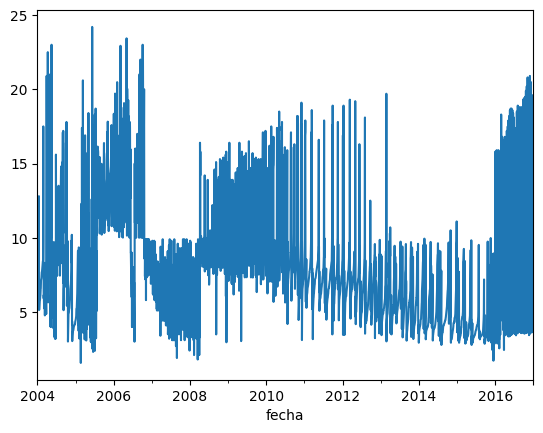

In [81]:
df1.plot()

El gráfico no muestra una tendencia clara a largo plazo. Se ven cambios bruscos de nivel en algunos años y periodos donde las subidas y bajadas son muy grandes, lo cual podría indicar valores atípicos o datos faltantes. Utilizando únicamente el gráfico no se puede asegurar que haya estacionalidad o no, debido al ruido y a los picos.

### 1.7
- Muestre el histograma de la variable series.
- ¿Qué conclusiones puede sacar del comportamiento de los datos?

<Axes: >

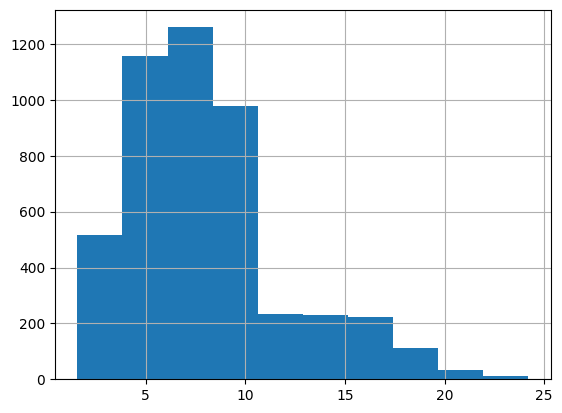

In [82]:
df1.hist()

El gráfico muestra que la distribución concentra la mayoría de los valores entre 5 y 10, generando una cola hacia la derecha que incluye algunos valores altos. Debido a esta cola la media probablemente sea superior a la mediana, así que utilizar únicamente el promedio podría dar la impresión de que los valores son más altos de lo que es típico.

### 1.8
- Agrupe los datos de la variable serie de manera Anual, y muestre los `boxplot` de cada año.
1. ¿Cómo se interpreta un gráfico `boxplot`?
2. ¿Qué conclusiones puede sacar del comportamiento de los datos?

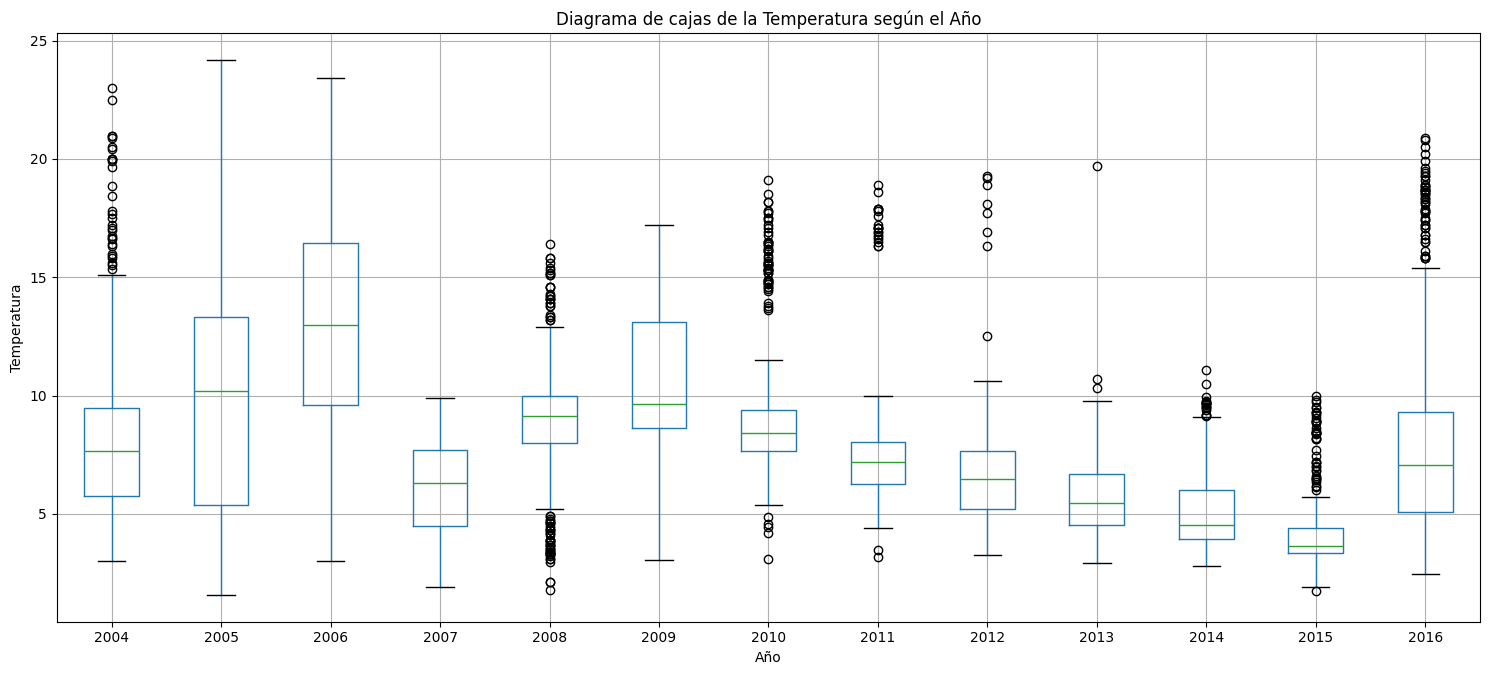

In [83]:
df1_yearly = df1.to_frame().assign(year=df1.index.year)

plt.figure(figsize=(15, 7))
df1_yearly.boxplot(column="temperatura", by="year", ax=plt.gca())
plt.title("Diagrama de cajas de la Temperatura según el Año")
plt.xlabel("Año")
plt.ylabel("Temperatura")
plt.suptitle("")
plt.tight_layout()
plt.show()

#### 1. ¿Cómo se interpreta un gráfico `boxplot`?

1. La _caja_ va de **Q1** (25%) a **Q3** (75%).
2. La altura de la _caja_ es el **IQR** o rango intercuartílico.
3. La línea que está dentro de la caja es la mediana (**Q2**).
4. Los bigotes llegan la valor más extremo en el rango de $[\text{Q1} - 1.5 \times \text{IQR}, \text{Q3} + 1.5 \times \text{IQR}]$.
5. Los puntos fuera de los bigotes son los posibles valores atípicos o _outliers_.

#### 2. ¿Qué conclusiones puede sacar del comportamiento de los datos?

- Entre 2004 a 2006 se ven niveles más altos y con mayor variabilidad.
- De 2007 a 2015 los niveles son más bajos con una dispersión menor.
- 2016 vuelve a tener niveles más altos y con mayor variabilidad.

### 1.9
- Muestre el Lag Scatter plot de la variable series.
    1. ¿Cómo se interpreta un Lag Scatter plot?
    2. ¿Qué conclusiones puede sacar del comportamiento de los datos?

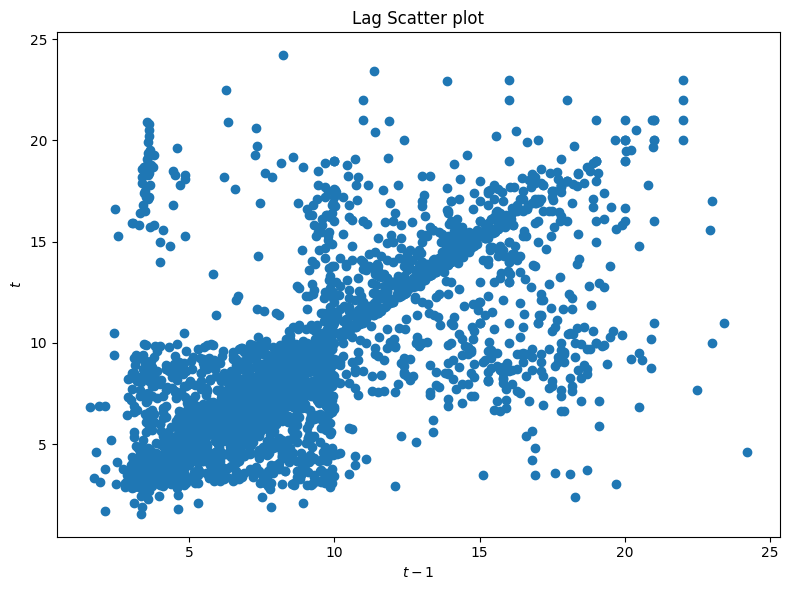

In [84]:
plt.figure(figsize=(8, 6))
lag_plot(df1, lag=1)
plt.title("Lag Scatter plot")
plt.xlabel("$t-1$")
plt.ylabel("$t$")
plt.tight_layout()
plt.show()

#### 1. ¿Cómo se interpreta un Lag Scatter plot?

- Cada punto compara un valor en $t-1$ con un valor en $t$ (para un _lag_ de 1).
- Una nube alargada en diagonal ascendente indica que hay una _autocorrelación positiva_ (valores consecutivos tienden a parecerse).
- Una nube casi circular sugiere poca correlación.
- Puntos alejados del grupo son posibles valores atípicos.

#### 2. ¿Qué conclusiones puede sacar del comportamiento de los datos?

Se observa una _autocorrelación positiva_ entre $t-1$ y $t$. La nube de puntos se alarga en sentido ascendente lo que indica una dependencia a corto plazo. En los valores bajos hay mucha concentración mientras que en valores altos la dispersión es mayor. También hay puntos alejados que son posibles valores atípicos.

### 1.10
- Muestre el gráfico autocorrelación de la variable series.
    1. ¿Cómo se interpreta este tipo de gráficos?
    2. ¿Qué conclusiones puede sacar del comportamiento de los datos?

<Figure size 1000x600 with 0 Axes>

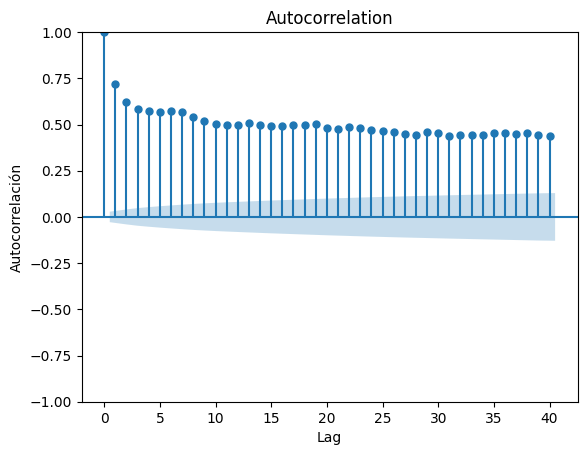

In [85]:
plt.figure(figsize=(10, 6))
plot_acf(df1, lags=40)
plt.xlabel("Lag")
plt.ylabel("Autocorrelación")
plt.show()

#### 1. ¿Cómo se interpreta este tipo de gráficos?

1. En el _lag_= 0 el valor de y siempre es 1 es la serie consigo misma.
2. Las barras altas y positivas en _lags_ pequeños indican fuerte autocorrelación positiva, es decir los valores consecutivos se parecen.
3. Las barras negativas indican autocorrelación negativa, los valores alternan (suben y bajan).
4. Si se presenta disminución gradual (_decay_) esto puede sugerir la precnsia de tendencia o no estacionariedad.
5. Si los valores tienen un patrón oscilante (entre positivo y negativo) eso es señal de estacionalidad (por ejemplo, picos cada 12 lags en datos mensuales).
6. Las barras dentro de la franja de color sugieren que no hay una correlación significativa en ese valor de _lag_ (comportamiento aleatorio).

#### 2. ¿Qué conclusiones puede sacar del comportamiento de los datos?

1. Existe un alta autocorrelación en lags cortos, por ejemplo el _lag_ 1 tiene un valor cercano a 0.7, lo que indica que los valores consecutivos están fuertemente relacionados.
2. Hay un decaimiento lento y persistente, las barras permanecen positivas y significativas al menos hasta el lag 40.
3. No se observan picos regulares que vuelvan a subir y bajar, por lo que no hay evidencia clara de estacionalidad diaria en los primeros 40 _lags_. Aun asi es posible que exista extacionalidad en periodos mas largos de _lags_.

# Parte 2. Diferenciación (15 puntos)

1. Luego, **utilizando el archivo `TS_d_2.csv`** realice la presente sección.
2. Complete en celdas de código y/o texto según convenga.
3. Documente bien su código.

### 2.1
- Cargue el archivo proporcionado y muestre los 10 primeros registros.

In [86]:
df2 = pd.read_csv("./data/TS_d_2.csv", index_col=0).iloc[:, 0].astype("float64")
df2.index = pd.to_datetime(df2.index, format="%d/%m/%Y")
df2.head(10)

fecha
2000-01-01    0.89
2000-02-01    0.86
2000-03-01    0.89
2000-04-01    0.83
2000-05-01    0.83
2000-06-01    0.85
2000-07-01    0.95
2000-08-01    0.89
2000-09-01    0.82
2000-10-01    0.72
Name: humedad, dtype: float64

### 2.2
- Aplique el Augmented Dickey-Fuller test, con una confianza estadística del 95% (por lo tanto un threshold del 0.05)
- Explique los resultados

In [87]:
dicker_fuller = cast(tuple[Any, ...], adfuller(df2))
print(f"""
ADF Statistic: {dicker_fuller[0]:.3f}
p-value: {dicker_fuller[1]:.8f}
Critical Values:
{"\n".join([f"\t{key}: {value:.3f}" for key, value in dicker_fuller[4].items()])}
""")


ADF Statistic: -6.070
p-value: 0.00000012
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.573



#### Explicación

Con un nivel de confianza del 95% tenemos una muy alta certeza de que los datos son estacionarios debido a que el $p$-value es de $0.00000012$. Lo cual es mucho menor a $0.05$.

Reforzando esto el _ADF Statistic_ es de $-6.070$ lo cual es mucho menor que el valor crítico al 5% ($–2.874$), por cual también tenemos una muy alta certeza de los que los datos son estacionarios.

Debido a esto rechazamos la hipótesis nula.

### 2.3
- Aplique la "Diferenciación" a la serie, y al resultado vuelva a aplicarle el Augmented Dickey-Fuller test, con una confianza estadística del 95% (por lo tanto un threshold del 0.05)
- Explique los resultados

Antes de _diferenciar_ necesitamos encontrar cuál es un número adecuado de _lags_ para realizar la _diferenciación_. Para poder realizar esto utilizamos un gráfico de autocorrelación. En este gráfico podemos ver un patrón ondulante con picos en 12, 24, 36. Esto es típico de datos mensuales, por lo que utilizamos un número de _lags_ de $12$.

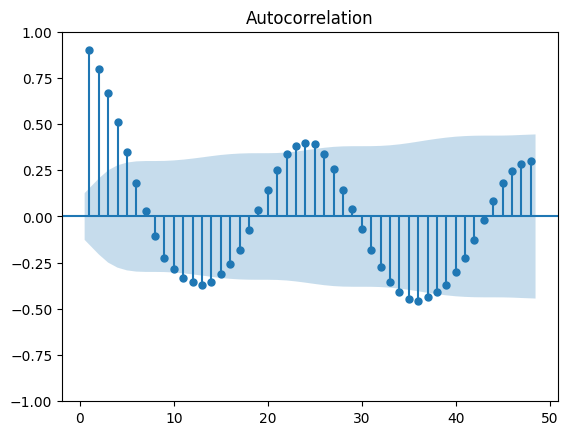

In [88]:
plot_acf(df2, lags=48, zero=False)
plt.show()

Con el código a continuación estamos aplicando _diferenciación_ a la serie:

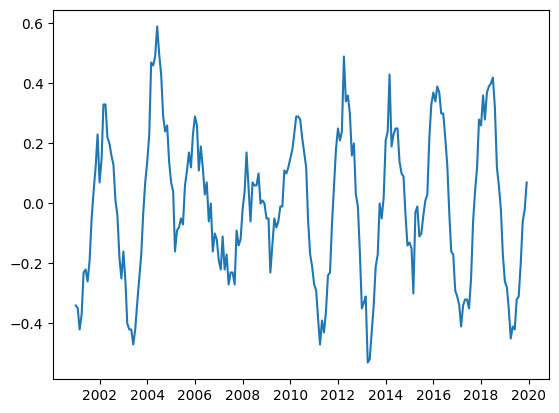

In [89]:
diff = df2.diff(12).dropna()

plt.plot(diff)
plt.show()

Con el código a continuación se aplica el _Augmented Dickey-Fuller test_:

In [90]:
dicker_fuller = cast(tuple[Any, ...], adfuller(diff))
print(f"""
ADF Statistic: {dicker_fuller[0]:.3f}
p-value: {dicker_fuller[1]:.3f}
Critical Values:
{"\n".join([f"\t{key}: {value:.3f}" for key, value in dicker_fuller[4].items()])}
""")


ADF Statistic: -3.406
p-value: 0.011
Critical Values:
	1%: -3.461
	5%: -2.875
	10%: -2.574



#### Explicación

El _ADF_ con una _diferenciación_ de 12 da un $p-value$ de $0.011$ lo cual es menor a $0.05$ y un valor estadístico de $-3.406$ el cuál es menor al valor crítico al 5% de $-2.875$. Debido a esto podemos rechazar $H_0$ y la serie se comporta como una serie estacionaria.

**NOTA:** la serie original ya era estacionaria con un margen mayor, así que la diferenciación con _lag_ de 12 solo sirvió para atenuar el componente estacional visto en el _ACF_.

Esto lo podemos ver en el gráfico _ACF_ que se puede ver a continuación:

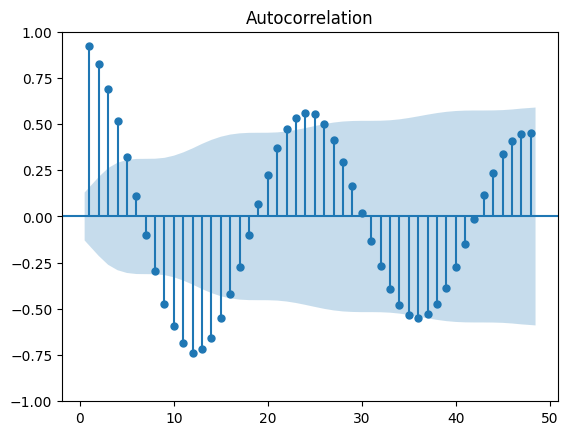

In [91]:
plot_acf(diff, lags=48, zero=False)
plt.show()

### 2.4
- ¿Esta serie requería Diferenciación o no? Explique el gráfico generado, ¿por qué sé mira así relacionado con la necesidad o no de diferenciación?

El propósito de la diferenciación es transformar una serie de tiempo no estacionaria en una que sí lo sea. Como nuestra serie de tiempo ya era estacionaria hacer uso de este proceso no era necesario, y más bien debilitó la señal de los datos.

# Parte 3.  ARIMA (15 puntos)

1. Luego, **utilizando el archivo `TS_d_3.csv`** realice la presente sección.
2. Complete en celdas de código y/o texto según convenga.
3. Documente bien su código.

### 3.1
- Explique en qué consiste ARIMA.

ARIMA es un acrónimo para la frase en inglés _AutoRegressive Integrated Moving Average_. Es utilizado para el análisis y predicción de series temporales. El acrónico de ARIMA es descriptivo, capturando los aspectos clave del modelo:

- **AR**: _AutoRegressive_. Es un modelo que utiliza las relaciones dependientes entre una observación y algún número de observaciones _lags_.
- **I**: _Integrated_. El uso de diferenciación de las observaciones para hacer que la serie de tiempo fuera estacionaria.
- **MA**: _Moving Average_. Es un modelo que utiliza la dependencia entre una observación y un error residual de un modelo _moving average_ aplicado a las observaciones con _lag_.

### 3.2
- Cargue el archivo y use los gráficos que considere prudente para ver cómo se comportan los datos
- Comente sus conclusiones

In [92]:
df3 = pd.read_csv("./data/TS_d_3.csv", index_col=0).iloc[:, 0].astype("float64")
df3.index = pd.to_datetime(df3.index, format="%d/%m/%Y")
df3 = df3.asfreq(pd.infer_freq(df3.index) or "D")
df3.index = cast(DatetimeIndex, df3.index)
df3.head()

fecha
2004-01-01    5.3
2004-01-02    5.6
2004-01-03    5.9
2004-01-04    6.2
2004-01-05    8.4
Freq: D, Name: temperatura, dtype: float64

Primero un gráfico simple para ver cómo se comporta la serie:

<Axes: xlabel='fecha'>

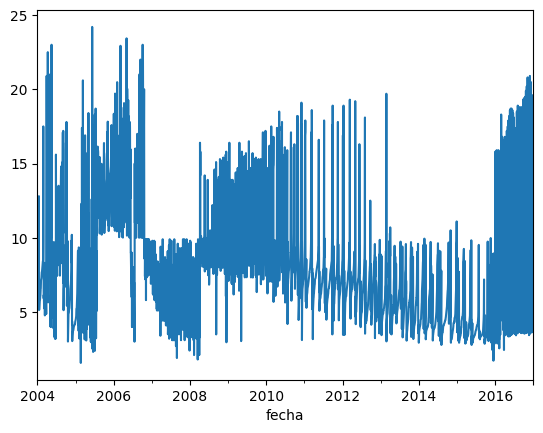

In [93]:
df3.plot()

Luego un histograma y un gráfico de densidad:

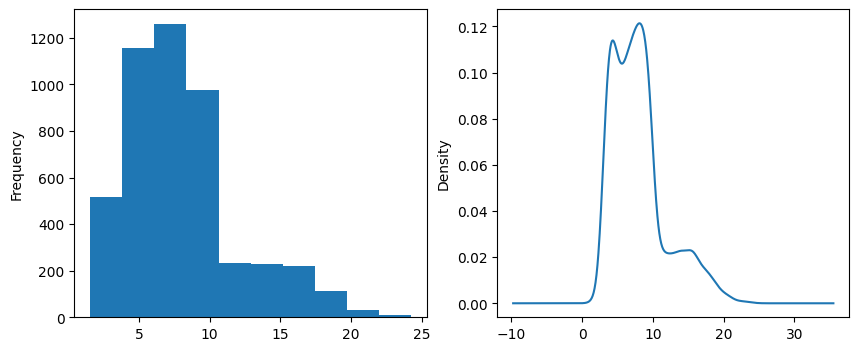

In [94]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
df3.plot.hist(ax=ax[0])
df3.plot.kde(ax=ax[1])
plt.show()

Luego un _box plot_ por año:

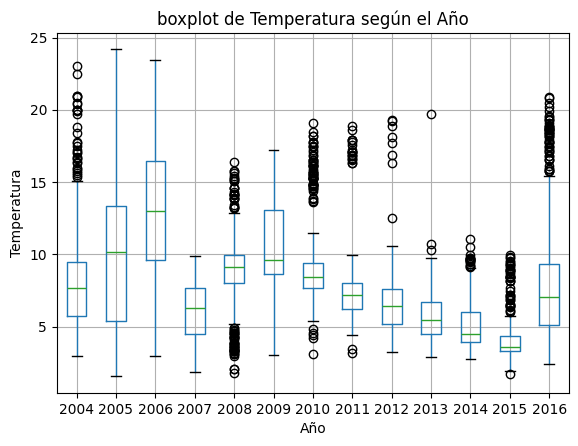

In [95]:
df3.to_frame().assign(year=df3.index.year).boxplot(column="temperatura", by="year")
plt.xlabel("Año")
plt.ylabel("Temperatura")
plt.title("boxplot de Temperatura según el Año")
plt.suptitle("")
plt.show()

También un _lag scatter plot_:

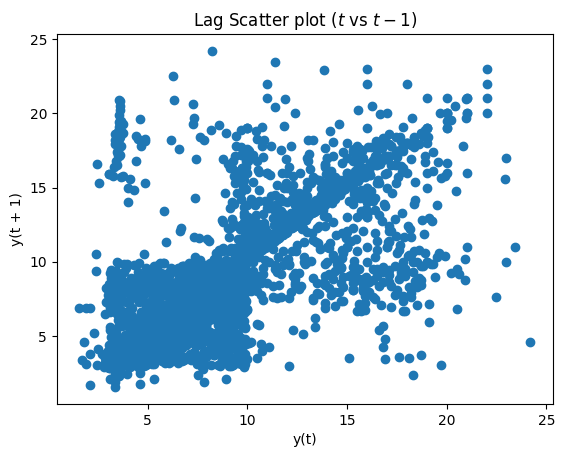

In [96]:
lag_plot(df3)
plt.title("Lag Scatter plot ($t$ vs $t-1$)")
plt.show()

Y finalmente un gráfico _ACF_:

<Figure size 1000x600 with 0 Axes>

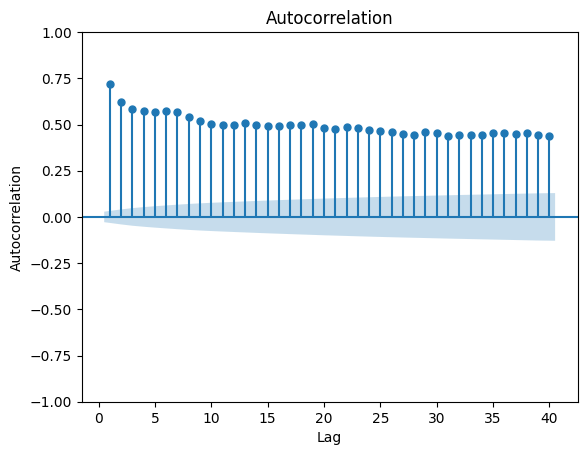

In [97]:
plt.figure(figsize=(10, 6))
plot_acf(df3, lags=40, zero=False)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.show()

#### Conclusiones

En base a los datos y gráficos anteriores podemos concluir preliminarmente que la serie no parece ser estacionaria. Esto debido a que la media cambia por periodos y la varianza también. Algunos años tienen alta dispersión y otros son más estables.

También se puede ver que hay autocorrelación (los datos actuales dependen fuertemente de los pasados).

Hay también años con outliers recurrentes. Hay años con temperaturas extremas que sobresalen del patrón normal.

### 3.3
- Analice si requiere hacer diferenciación o no. Explique

Debido a lo que observamos en los gráficos anteriores se requiere hacer diferenciación ya que la serie no parece ser estacionaria.

### 3.4
- Haga forecast (similar a las últimas secciones de ese capítulo), con un train de 80% y un test de 20% (no olvide que son series temporales, no datos i.i.d.)

In [98]:
size = int(len(df3) * 0.8)
train, test = df3.iloc[:size], df3.iloc[size:]

model = ARIMA(train, order=(5, 1, 0))
res = cast(ARIMAResults, model.fit())
pred_vals = []
for tstamp, y_t in test.items():
    yhat = res.get_forecast(steps=1).predicted_mean.iloc[0]
    pred_vals.append(yhat)
    res = res.append([y_t], refit=False)

pred = pd.Series(pred_vals, index=test.index)

rmse = math.sqrt(mean_squared_error(test, pred))
print(f"Test RMSE: {rmse:.3f}")

Test RMSE: 3.275


### 3.5
- Grafique el predicho versus el real y comente sus conclusiones.

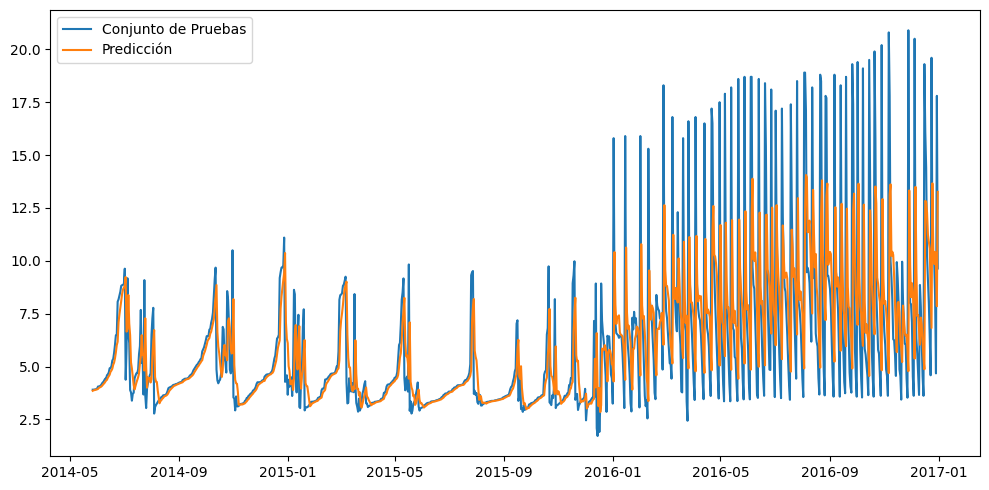

In [99]:
plt.figure(figsize=(10, 5))
plt.plot(test.index, test, label="Conjunto de Pruebas")
plt.plot(pred.index, pred, label="Predicción")
plt.legend()
plt.tight_layout()
plt.show()

1. Las predicciones (naranja) siguen bastante bien la serie real (azul), capturando la tendencia y parte de la estacionalidad a corto plazo, pero a partir de 2016: El modelo pierde precisión cuando la variabilidad aumenta (hay picos más altos y frecuentes). Las predicciones se suavizan y no alcanzan los valores extremos.
2. ARIMA capta la estructura general, pero no reproduce bien los picos ni la amplitud creciente.
3. El modelo funciona bien para periodos estables, pero falla ante cambios bruscos y estacionalidad fuerte.

# Parte 4. Regresión lineal y breve diseño experimental (20 puntos)

**Se le suministra un archivo llamado `TS_d_3.csv`**.

### 4.1
- Cargue el archivo en el orden en que vienen los datos y solo deje la columna temperatura.
- Muestre cuántas filas tiene el conjunto de datos.

In [100]:
df3 = pd.read_csv("./data/TS_d_3.csv", index_col=0).iloc[:, 0].astype("float64")
df3.index = pd.to_datetime(df3.index, format="%d/%m/%Y")
df3 = df3.asfreq(pd.infer_freq(df3.index) or "D")
df3.index = cast(DatetimeIndex, df3.index)

df3.size

4749

### 4.2
- Como es solo una serie temporal, divida entre X_train y X_test (70% y 30%). Note que por ahora no tiene y (ni y_train, ni y_test)
- Muestre los tres primeros registros.

In [101]:
size = int(len(df3) * 0.7)
train, test = df3.iloc[:size], df3.iloc[size:]

In [102]:
train.head(3)

fecha
2004-01-01    5.3
2004-01-02    5.6
2004-01-03    5.9
Freq: D, Name: temperatura, dtype: float64

In [103]:
test.head(3)

fecha
2013-02-06    5.62
2013-02-07    5.66
2013-02-08    5.77
Freq: D, Name: temperatura, dtype: float64

### 4.3
- Como todos los valores están en la misma escala y por si desea comprar el resultado con el ARIMA, no escale los datos. Ahora bien, entendiendo lo dicho anteriormente, puede escalar el X_train y X_test utilizando MinMaxScaler (pero cuidado al interpretar valores como el MSE).
- Indique qué decisión tomó y por qué.
- Muestre los tres primeros registros.

In [104]:
scaler = MinMaxScaler((0.0, 1.0))

train_scaled = scaler.fit_transform(train.to_frame())
train_scaled = pd.Series(train_scaled.flatten(), index=train.index).astype("float64")

test_scaled = scaler.transform(test.to_frame())
test_scaled = pd.Series(test_scaled.flatten(), index=test.index).astype("float64")

Se decidió escalar los datos a valores entre 0 y 1, esto debido a que para muchos modelos normalizar los datos de esta forma da mejores predicciones y para que se pueda experimentar en este trabajo con los datos escalados.

In [105]:
train_scaled.head(3)

fecha
2004-01-01    0.164825
2004-01-02    0.178082
2004-01-03    0.191339
Freq: D, dtype: float64

In [106]:
test_scaled.head(3)

fecha
2013-02-06    0.178966
2013-02-07    0.180734
2013-02-08    0.185594
Freq: D, dtype: float64

### 4.4
- Utilizando la técnica de Lag Features, procese tanto el train como el test con los valores y un Lag=5 y ahora si va tener y_train y y_test, pues serán el siguiente periodo a predecir.
- Muestre los tres primeros registros de cada uno.

In [107]:
train_lagged = pd.concat(
    {
        "t+1": train_scaled,
        **{("t" if i == 1 else f"t-{i - 1}"): train_scaled.shift(i) for i in range(1, 6)},
    },
    axis=1,
).dropna()
train_lagged.head(3)

,t+1,t,t-1,t-2,t-3,t-4
fecha,,,,,,
2004-01-06,0.279717,0.301812,0.204596,0.191339,0.178082,0.164825
2004-01-07,0.266460,0.279717,0.301812,0.204596,0.191339,0.178082
2004-01-08,0.270879,0.266460,0.279717,0.301812,0.204596,0.191339


In [108]:
y_train = train_lagged["t+1"]
x_train = train_lagged.drop(columns=["t+1"])

In [109]:
y_train.head(3)

fecha
2004-01-06    0.279717
2004-01-07    0.266460
2004-01-08    0.270879
Freq: D, Name: t+1, dtype: float64

In [110]:
x_train.head(3)

,t,t-1,t-2,t-3,t-4
fecha,,,,,
2004-01-06,0.301812,0.204596,0.191339,0.178082,0.164825
2004-01-07,0.279717,0.301812,0.204596,0.191339,0.178082
2004-01-08,0.266460,0.279717,0.301812,0.204596,0.191339


In [111]:
test_lagged = pd.concat(
    {
        "t+1": test_scaled,
        **{("t" if i == 1 else f"t-{i - 1}"): test_scaled.shift(i) for i in range(1, 6)},
    },
    axis=1,
).dropna()
test_lagged.head(3)

,t+1,t,t-1,t-2,t-3,t-4
fecha,,,,,,
2013-02-11,0.212992,0.191781,0.191781,0.185594,0.180734,0.178966
2013-02-12,0.226248,0.212992,0.191781,0.191781,0.185594,0.180734
2013-02-13,0.229783,0.226248,0.212992,0.191781,0.191781,0.185594


In [112]:
y_test = test_lagged["t+1"]
x_test = test_lagged.drop(columns=["t+1"])

In [113]:
y_test.head(3)

fecha
2013-02-11    0.212992
2013-02-12    0.226248
2013-02-13    0.229783
Freq: D, Name: t+1, dtype: float64

In [114]:
x_test.head(3)

,t,t-1,t-2,t-3,t-4
fecha,,,,,
2013-02-11,0.191781,0.191781,0.185594,0.180734,0.178966
2013-02-12,0.212992,0.191781,0.191781,0.185594,0.180734
2013-02-13,0.226248,0.212992,0.191781,0.191781,0.185594


### 4.5
- Vamos ahora a utilizar `sklearn` para calcular los pesos.
- Utilizando algún algoritmo de regresión de la biblioteca `sklearn` ajuste el modelo y calcule $y_{pred}$, calcule las métricas $R2$ y $MSE$ entre el $y_{pred}$ y el $y_{test}$.
- Comente los resultados obtenidos

In [115]:
model = LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.4f}")

R²: 0.1997
MSE: 0.0154


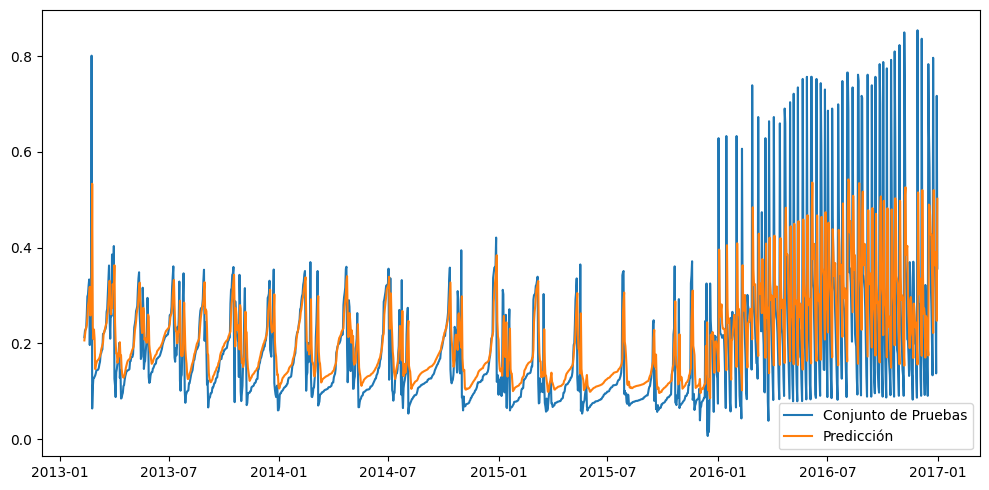

In [116]:
pred = pd.Series(y_pred, index=y_test.index)
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label="Conjunto de Pruebas")
plt.plot(pred.index, pred, label="Predicción")
plt.legend()
plt.tight_layout()
plt.show()

1. El modelo logra seguir la tendencia general de la serie en la mayor parte del conjunto de prueba. Sin embargo, no captura bien los picos ni las caídas abruptas (especialmente en 2016), esto indica que las transformaciones dadas no son suficientes para modelar la dinámica completa de los valores en la serie de tiempo original.

2. Como R² = 0.1997 la relación lineal entre los 5 retrasos y el valor futuro _t+1_ es débil. Puede ser que para una serie de tiempo con valores diarios y con posible estacionalidad y picos, no se capture toda la complejidad de los datos y eso afecte las predicciones.

3. Como MSE = 0.0154 en escala 0-1 es significativo porque la escala es pequeña. Podemos ver que en periodos donde los valores son menos extremos el error es bajo lo cual compone la mayor parte de la serie, los picos extremos pueden ser outliers o valores atípicos que podrían desaparecer con mejor ajuste o transformación.

4. Visualmente el modelo sigue la tendencia general en periodos estables, pero pierde precisión en 2016 y al inicio del 2013, donde hay mayor variabilidad y picos.

# Parte 5.  Uso de biblioteca Prophet (15 puntos)

**Se le suministra un archivo llamado `trainV.csv`**.

Estudie el código que se le proporciona, luego busque otra serie temporal y aplique un proceso similar.

---

La serie temporal que se va a utilizar está en el siguiente enlace: <https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data>

Es una serie temporal que provee los datos de temperatura promedio, humedad, velocidad del viento y presión atmosférica promedio del 1 de enero del 2013 al 24 de abril del 2027.

In [126]:
delhi_df = (
    pd.read_csv("./data/DailyDelhiClimate.csv", parse_dates=["date"], usecols=["date", "meantemp"])
    .rename(columns={"date": "ds", "meantemp": "y"})
    .dropna()
    .sort_values("ds")
)

display(delhi_df.size)
display(delhi_df.head(20))

3152

,ds,y
0,2013-01-01,10.000000
1,2013-01-02,7.400000
2,2013-01-03,7.166667
3,2013-01-04,8.666667
4,2013-01-05,6.000000
5,2013-01-06,7.000000
6,2013-01-07,7.000000
7,2013-01-08,8.857143
8,2013-01-09,14.000000
9,2013-01-10,11.000000


In [127]:
split = int(len(delhi_df) * 0.7)
train = delhi_df.iloc[:split].copy()
test = delhi_df.iloc[split:].copy()

display({"train": len(train), "test": len(test)})

{'train': 1103, 'test': 473}

In [131]:
m = Prophet(
    growth="linear",
    yearly_seasonality="auto",
    weekly_seasonality="auto",
    daily_seasonality="auto",
    seasonality_mode="additive",
    changepoint_prior_scale=0.05,
)
m.fit(train)

future_test = test[["ds"]].copy()
forecast_test = m.predict(future_test)

comp = test.merge(forecast_test[["ds", "yhat", "yhat_lower", "yhat_upper"]], on="ds", how="left")
display(comp.head(10))

15:56:21 - cmdstanpy - INFO - Chain [1] start processing
15:56:21 - cmdstanpy - INFO - Chain [1] done processing


,ds,y,yhat,yhat_lower,yhat_upper
0,2016-01-09,15.857143,13.002066,10.459329,15.544367
1,2016-01-10,15.625000,13.003473,10.485772,15.586243
2,2016-01-11,15.750000,13.406689,10.820778,15.900584
3,2016-01-12,18.000000,13.529970,10.817153,15.956664
4,2016-01-13,18.266667,13.745993,11.114901,16.402003
5,2016-01-14,15.562500,13.690260,11.036435,16.355111
6,2016-01-15,13.000000,13.704929,11.041599,16.304759
7,2016-01-16,13.600000,13.726452,11.259437,16.329497
8,2016-01-17,14.000000,13.722828,11.267470,16.221298
9,2016-01-18,13.266667,14.118245,11.315406,16.661619


In [133]:
def calc_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))


def calc_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))


def calc_mape(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    eps = 1e-8
    return np.mean(np.abs((y_true - y_pred) / (np.maximum(np.abs(y_true), eps)))) * 100


print(f"MAE:  {calc_mae(comp['y'], comp['yhat']):.3f}")
print(f"RMSE: {calc_rmse(comp['y'], comp['yhat']):.3f}")
print(f"MAPE: {calc_mape(comp['y'], comp['yhat']):.2f}%")

MAE:  1.940
RMSE: 2.414
MAPE: 8.27%


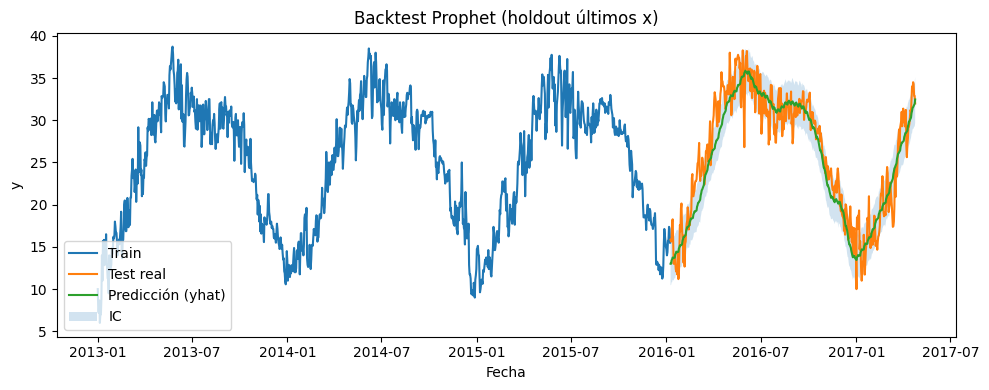

In [134]:
plt.figure(figsize=(10, 4))
plt.plot(train["ds"], train["y"], label="Train")
plt.plot(comp["ds"], comp["y"], label="Test real")
plt.plot(comp["ds"], comp["yhat"], label="Predicción (yhat)")
plt.fill_between(comp["ds"], comp["yhat_lower"], comp["yhat_upper"], alpha=0.2, label="IC")
plt.legend()
plt.title("Backtest Prophet (holdout últimos x)")
plt.xlabel("Fecha")
plt.ylabel("y")
plt.tight_layout()
plt.show()

### 5.1 Comente las principales conclusiones que obtiene luego de aplicar esta biblioteca a la serie temporal que Usted proporcionó

- El modelo creado con la librería `prophet` capta bien el patrón anual de la temperatura. La predicción sigue las subidas que ocurren en verano y las bajadas que ocurren en invierno, suavizando el ruido diario.
- El valor de _MAE_ muestra que el error típico ronda los 1.94 °C y el valor de _MAPE_ muestra que el error relativo está por debajo del 10% (8.27%) lo cual está bastante bien.
- La banda de incertidumbre cubre gran parte de los datos de prueba, donde falla tiende a ser donde hay picos o valores extremos.

---

**Nota Aclarativa:** Se han utilizado las siguientes herramientas de IA generativa: ChatGPT (GPT5, GPT5-Codex), Gemini (2.5 Flash, 2.5 Pro), Copilot (GPT5). Su uso se limitó a revisión de código y redacción, ayuda para el análisis de gráficos, y también se utilizó para consultar la documentación de todas las librerías y mantener estándares modernos con el código. Todo el contenido ha sido revisado, verificado y complementado con nuestro aporte personal.